In [1]:
#Set few things up for autoreloading and graph plotting
%load_ext autoreload
%autoreload 2

%pylab inline
%config InlineBackend.figure_format = 'retina'
sys.path.append("./src")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import tqdm
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [16]:
from database import *
from model import *
from utils import *
from train import *

### Set seeds and GPU

In [4]:
nxseed = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.random.seed(5)
torch.manual_seed(5)
if device is not "cpu":
    torch.cuda.manual_seed(5)
    
activation_dict = {
    'linear' : None,
    'relu' : F.relu
}

In [5]:
class Fullyconnected(nn.Module):
    def __init__(self, inputnodefeat, units, outputnodefeat, activation):
        super(Fullyconnected, self).__init__()
        self.inputnodefeat = inputnodefeat
        self.units = units
        self.outputnodefeat = outputnodefeat
        self.activation = activation
        self.linearlayers = nn.ModuleList()
        self.units = [inputnodefeat] + units + [outputnodefeat]
        for i in range(1, len(self.units)):
            self.linearlayers.append(nn.Linear(in_features = self.units[i-1], out_features = self.units[i]).to(device))
    def forward(self, adj, h):
        y = adj.view(adj.size(0), -1)
        for linearlayer in self.linearlayers:
            y = linearlayer(y)
            if(self.activation != "linear"):
                y = activation_dict[self.activation](y)
        return y

In [6]:
def generate_ERfullyconnected(params):

    graphdatabase = GraphData(params["n_sample"], params["node"], p_list = params["p_list"])
    graphdatabase.generate_ERGraphs()
    graphdatabase.generate_adjs()
    graphdatabase.graphadjs = shuffle_graphadjs(graphdatabase.graphadjs)
    graphdatabase.generate_moments(params["moment"])
    
    ADJ = np.array(graphdatabase.graphadjs)
    Y = graphdatabase.moments[params["moment"]]
    h = np.ones(ADJ.shape[:2]+(1,))
    return ADJ, Y, h

In [10]:
results = {}
n_samples = [5e02, 1e03, 4e03, 1e04]
moment = 1
node = 4

for n_sample in n_samples:
    print('Number of Samples :', n_sample)
    results[n_sample] = {}
    params = {
        "n_sample" : n_sample, 
        "node" : node,
        "p_list" : [2.0/node],
        "moment" : moment,
        "activation" : "relu"
    }
    ADJ, Y, h = generate_ERfullyconnected(params)
    
    for unit in np.linspace(5, 35, 10):
        unit = int(unit)
        print("Number of Units :", unit)
        results[n_sample][unit] = {}
        units = [unit]
        net = Fullyconnected(params["node"]**2, units, params["node"], params["activation"]).to(device)        
        
        #Define the loss function
        loss_fn = nn.MSELoss(reduction='mean')
        #Define the optimiser
        optimizer = optim.Adam(net.parameters(), lr=.001)
        #Define the training step to train the model
        train_step = make_train_step(net, loss_fn, optimizer)
        #Make the dataloader
        train_loader, val_loader = make_loader([ADJ, h], Y, None, .2)
        #Train the model
        training_losses, validation_losses, training_accuracy, validation_accuracy = \
        train_model(net, device, train_step, loss_fn, 500, train_loader, val_loader)

        #Save the model results
        results[n_sample][unit] = {"loss": training_losses, "val_loss" :validation_losses, \
                              "train_accuracy": training_accuracy, "val_accuracy": validation_accuracy}

Number of Samples : 500.0
Number of Units : 5
[1] Training loss: 2.512725	 Validation loss: 2.250134
[1] Training Accuracy: 2.513	 Validation Accuracy: 2.250
[2] Training loss: 2.507164	 Validation loss: 2.245195
[2] Training Accuracy: 2.507	 Validation Accuracy: 2.245
[3] Training loss: 2.501594	 Validation loss: 2.240354
[3] Training Accuracy: 2.502	 Validation Accuracy: 2.240
[4] Training loss: 2.496100	 Validation loss: 2.235585
[4] Training Accuracy: 2.496	 Validation Accuracy: 2.236
[5] Training loss: 2.490677	 Validation loss: 2.230813
[5] Training Accuracy: 2.491	 Validation Accuracy: 2.231
[6] Training loss: 2.485285	 Validation loss: 2.226095
[6] Training Accuracy: 2.485	 Validation Accuracy: 2.226
[7] Training loss: 2.480083	 Validation loss: 2.221347
[7] Training Accuracy: 2.480	 Validation Accuracy: 2.221
[8] Training loss: 2.474936	 Validation loss: 2.216422
[8] Training Accuracy: 2.475	 Validation Accuracy: 2.216
[9] Training loss: 2.469709	 Validation loss: 2.211229
[9]

[72] Training Accuracy: 2.089	 Validation Accuracy: 1.865
[73] Training loss: 2.081153	 Validation loss: 1.858074
[73] Training Accuracy: 2.081	 Validation Accuracy: 1.858
[74] Training loss: 2.073424	 Validation loss: 1.851105
[74] Training Accuracy: 2.073	 Validation Accuracy: 1.851
[75] Training loss: 2.065629	 Validation loss: 1.844080
[75] Training Accuracy: 2.066	 Validation Accuracy: 1.844
[76] Training loss: 2.057771	 Validation loss: 1.837003
[76] Training Accuracy: 2.058	 Validation Accuracy: 1.837
[77] Training loss: 2.049850	 Validation loss: 1.829868
[77] Training Accuracy: 2.050	 Validation Accuracy: 1.830
[78] Training loss: 2.041866	 Validation loss: 1.822671
[78] Training Accuracy: 2.042	 Validation Accuracy: 1.823
[79] Training loss: 2.033813	 Validation loss: 1.815424
[79] Training Accuracy: 2.034	 Validation Accuracy: 1.815
[80] Training loss: 2.025704	 Validation loss: 1.808125
[80] Training Accuracy: 2.026	 Validation Accuracy: 1.808
[81] Training loss: 2.017535	 

KeyboardInterrupt: 

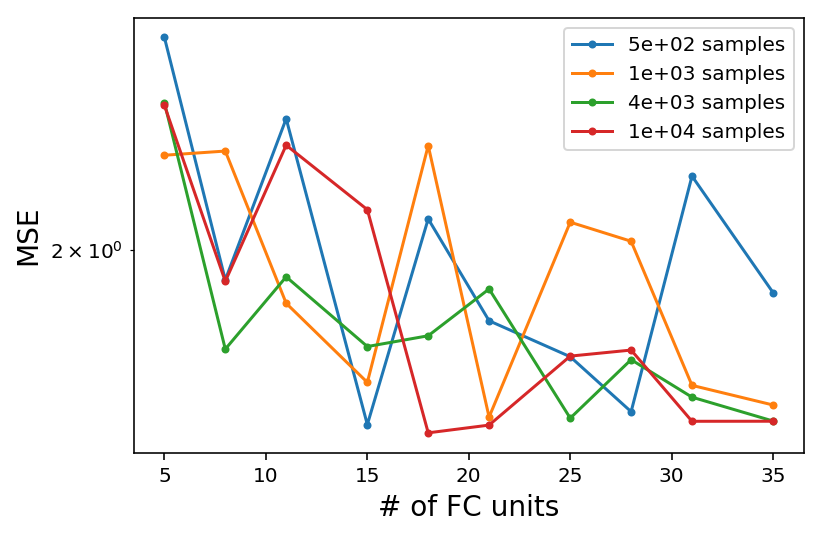

In [19]:
for num in sorted(results)[:]:
    us, loss, val_loss = [], [],[]
    for u in sorted(results[num]):
        us += [u]
        # find best fit
        i = argmin(results[num][u]['val_loss'])
        loss += [results[num][u]['loss'][i]]
        val_loss += [results[num][u]['val_loss'][i]]
        
    #plot(us,loss)
    plot(us, val_loss,'.-', label = '%.1g samples' %num)

legend()
ylabel('MSE', size = 14)
xlabel('# of FC units', size = 14)
yscale('log')

In [14]:
def generate_BAgcnn(params):

    graphdatabase = GraphData(params["n_sample"], params["node"], m_list = params["m_list"])
    graphdatabase.generate_BAGraphs()
    graphdatabase.generate_adjs()
    graphdatabase.graphadjs = shuffle_graphadjs(graphdatabase.graphadjs)
    graphdatabase.generate_moments(params["moment"])
    
    ADJ = np.array(graphdatabase.graphadjs)
    Y = graphdatabase.moments[params["moment"]]
    h = np.ones(ADJ.shape[:2]+(1,))
    return ADJ, Y, h

In [15]:
class GCN_onelayer(nn.Module):
    def __init__(self, inputnodefeat, outputnodefeat, activation):
        super(GCN_onelayer, self).__init__()
        self.inputnodefeat = inputnodefeat
        self.outputnodefeat = outputnodefeat
        self.activation = activation
        self.gcn = GCN(self.inputnodefeat, self.outputnodefeat, self.activation)
    def forward(self, adj, h):
        y = self.gcn(adj, h)
        y = y.view(y.size(0), -1)
        return y

In [71]:
results = {}
moment = 1

for n_sample in np.int0(np.logspace(np.log10(5e2), np.log10(1e4), 4))[::-1]:
    print('Number of Samples :', n_sample)
    results[n_sample] = {}
    params = {
        "n_sample" : n_sample, 
        "node" : 20,
        "m_list" : [2.0],
        "moment" : moment,
        "activation" : "linear"
    }
    ADJ, Y, h = generate_BAgcnn(params)
    
    net = GCN_onelayer(1, 1, params["activation"]).to(device)        

    #Define the loss function
    loss_fn = nn.MSELoss(reduction='mean')
    #Define the optimiser
    optimizer = optim.Adam(net.parameters(), lr=.02)
    #Define the training step to train the model
    train_step = make_train_step(net, loss_fn, optimizer)
    #Make the dataloader
    train_loader, val_loader = make_loader([ADJ, h], Y, None, .2)
    #Train the model
    epochs = (2000*200)//n_sample
    training_losses, validation_losses, training_accuracy, validation_accuracy = \
    train_model(net, device, train_step, loss_fn, epochs, train_loader, val_loader)

    #Save the model results
    results[n_sample] = {"loss": training_losses, "val_loss" :validation_losses, \
                          "train_accuracy": training_accuracy, "val_accuracy": validation_accuracy}

Number of Samples : 10000
[1] Training loss: 33.996017	 Validation loss: 32.899956
[1] Training Accuracy: 33.996	 Validation Accuracy: 32.900
[2] Training loss: 32.816380	 Validation loss: 31.739725
[2] Training Accuracy: 32.816	 Validation Accuracy: 31.740
[3] Training loss: 31.658522	 Validation loss: 30.601671
[3] Training Accuracy: 31.659	 Validation Accuracy: 30.602
[4] Training loss: 30.522802	 Validation loss: 29.486137
[4] Training Accuracy: 30.523	 Validation Accuracy: 29.486
[5] Training loss: 29.409575	 Validation loss: 28.393454
[5] Training Accuracy: 29.410	 Validation Accuracy: 28.393
[6] Training loss: 28.319151	 Validation loss: 27.323904
[6] Training Accuracy: 28.319	 Validation Accuracy: 27.324
[7] Training loss: 27.251827	 Validation loss: 26.277765
[7] Training Accuracy: 27.252	 Validation Accuracy: 26.278
[8] Training loss: 26.207874	 Validation loss: 25.255276
[8] Training Accuracy: 26.208	 Validation Accuracy: 25.255
[9] Training loss: 25.187531	 Validation loss:

[103] Training loss: 0.001747	 Validation loss: 0.001685
[103] Training Accuracy: 0.002	 Validation Accuracy: 0.002
[104] Training loss: 0.001675	 Validation loss: 0.001613
[104] Training Accuracy: 0.002	 Validation Accuracy: 0.002
[105] Training loss: 0.001605	 Validation loss: 0.001543
[105] Training Accuracy: 0.002	 Validation Accuracy: 0.002
[106] Training loss: 0.001535	 Validation loss: 0.001474
[106] Training Accuracy: 0.002	 Validation Accuracy: 0.001
[107] Training loss: 0.001466	 Validation loss: 0.001406
[107] Training Accuracy: 0.001	 Validation Accuracy: 0.001
[108] Training loss: 0.001398	 Validation loss: 0.001339
[108] Training Accuracy: 0.001	 Validation Accuracy: 0.001
Number of Samples : 1357
[1] Training loss: 0.146818	 Validation loss: 0.083627
[1] Training Accuracy: 0.147	 Validation Accuracy: 0.084
[2] Training loss: 0.082206	 Validation loss: 0.040420
[2] Training Accuracy: 0.082	 Validation Accuracy: 0.040
[3] Training loss: 0.039522	 Validation loss: 0.018261


[137] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[138] Training loss: 0.000000	 Validation loss: 0.000000
[138] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[139] Training loss: 0.000000	 Validation loss: 0.000000
[139] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[140] Training loss: 0.000000	 Validation loss: 0.000000
[140] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[141] Training loss: 0.000000	 Validation loss: 0.000000
[141] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[142] Training loss: 0.000000	 Validation loss: 0.000000
[142] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[143] Training loss: 0.000000	 Validation loss: 0.000000
[143] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[144] Training loss: 0.000000	 Validation loss: 0.000000
[144] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[145] Training loss: 0.000000	 Validation loss: 0.000000
[145] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[146] Trainin

[278] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[279] Training loss: 0.000000	 Validation loss: 0.000000
[279] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[280] Training loss: 0.000000	 Validation loss: 0.000000
[280] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[281] Training loss: 0.000000	 Validation loss: 0.000000
[281] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[282] Training loss: 0.000000	 Validation loss: 0.000000
[282] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[283] Training loss: 0.000000	 Validation loss: 0.000000
[283] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[284] Training loss: 0.000000	 Validation loss: 0.000000
[284] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[285] Training loss: 0.000000	 Validation loss: 0.000000
[285] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[286] Training loss: 0.000000	 Validation loss: 0.000000
[286] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[287] Trainin

[127] Training loss: 0.013010	 Validation loss: 0.012369
[127] Training Accuracy: 0.013	 Validation Accuracy: 0.012
[128] Training loss: 0.012794	 Validation loss: 0.012163
[128] Training Accuracy: 0.013	 Validation Accuracy: 0.012
[129] Training loss: 0.012580	 Validation loss: 0.011961
[129] Training Accuracy: 0.013	 Validation Accuracy: 0.012
[130] Training loss: 0.012369	 Validation loss: 0.011760
[130] Training Accuracy: 0.012	 Validation Accuracy: 0.012
[131] Training loss: 0.012161	 Validation loss: 0.011563
[131] Training Accuracy: 0.012	 Validation Accuracy: 0.012
[132] Training loss: 0.011955	 Validation loss: 0.011367
[132] Training Accuracy: 0.012	 Validation Accuracy: 0.011
[133] Training loss: 0.011752	 Validation loss: 0.011173
[133] Training Accuracy: 0.012	 Validation Accuracy: 0.011
[134] Training loss: 0.011551	 Validation loss: 0.010982
[134] Training Accuracy: 0.012	 Validation Accuracy: 0.011
[135] Training loss: 0.011353	 Validation loss: 0.010793
[135] Training 

[268] Training loss: 0.000600	 Validation loss: 0.000564
[268] Training Accuracy: 0.001	 Validation Accuracy: 0.001
[269] Training loss: 0.000584	 Validation loss: 0.000550
[269] Training Accuracy: 0.001	 Validation Accuracy: 0.001
[270] Training loss: 0.000569	 Validation loss: 0.000535
[270] Training Accuracy: 0.001	 Validation Accuracy: 0.001
[271] Training loss: 0.000554	 Validation loss: 0.000521
[271] Training Accuracy: 0.001	 Validation Accuracy: 0.001
[272] Training loss: 0.000539	 Validation loss: 0.000507
[272] Training Accuracy: 0.001	 Validation Accuracy: 0.001
[273] Training loss: 0.000525	 Validation loss: 0.000494
[273] Training Accuracy: 0.001	 Validation Accuracy: 0.000
[274] Training loss: 0.000511	 Validation loss: 0.000480
[274] Training Accuracy: 0.001	 Validation Accuracy: 0.000
[275] Training loss: 0.000497	 Validation loss: 0.000467
[275] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[276] Training loss: 0.000484	 Validation loss: 0.000455
[276] Training 

[409] Training loss: 0.000007	 Validation loss: 0.000007
[409] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[410] Training loss: 0.000007	 Validation loss: 0.000007
[410] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[411] Training loss: 0.000007	 Validation loss: 0.000006
[411] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[412] Training loss: 0.000007	 Validation loss: 0.000006
[412] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[413] Training loss: 0.000006	 Validation loss: 0.000006
[413] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[414] Training loss: 0.000006	 Validation loss: 0.000006
[414] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[415] Training loss: 0.000006	 Validation loss: 0.000005
[415] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[416] Training loss: 0.000006	 Validation loss: 0.000005
[416] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[417] Training loss: 0.000005	 Validation loss: 0.000005
[417] Training 

[550] Training loss: 0.000000	 Validation loss: 0.000000
[550] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[551] Training loss: 0.000000	 Validation loss: 0.000000
[551] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[552] Training loss: 0.000000	 Validation loss: 0.000000
[552] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[553] Training loss: 0.000000	 Validation loss: 0.000000
[553] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[554] Training loss: 0.000000	 Validation loss: 0.000000
[554] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[555] Training loss: 0.000000	 Validation loss: 0.000000
[555] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[556] Training loss: 0.000000	 Validation loss: 0.000000
[556] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[557] Training loss: 0.000000	 Validation loss: 0.000000
[557] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[558] Training loss: 0.000000	 Validation loss: 0.000000
[558] Training 

[691] Training loss: 0.000000	 Validation loss: 0.000000
[691] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[692] Training loss: 0.000000	 Validation loss: 0.000000
[692] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[693] Training loss: 0.000000	 Validation loss: 0.000000
[693] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[694] Training loss: 0.000000	 Validation loss: 0.000000
[694] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[695] Training loss: 0.000000	 Validation loss: 0.000000
[695] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[696] Training loss: 0.000000	 Validation loss: 0.000000
[696] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[697] Training loss: 0.000000	 Validation loss: 0.000000
[697] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[698] Training loss: 0.000000	 Validation loss: 0.000000
[698] Training Accuracy: 0.000	 Validation Accuracy: 0.000
[699] Training loss: 0.000000	 Validation loss: 0.000000
[699] Training 

In [72]:
results.keys()

dict_keys([10000, 3684, 1357, 499])

In [73]:
tempresulta = results.copy()

Text(0.5, 0, 'Samples x Epochs')

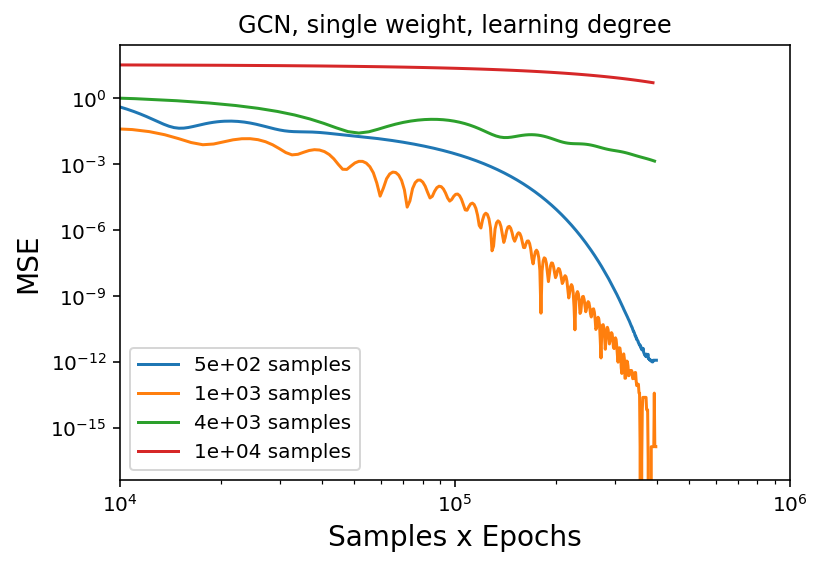

In [74]:
results = tempresulta
for k in sorted(results):
    for s in ['val_loss']:
        y = results[k][s]
        plot(arange(len(y))*k,y, label = '%.1g samples' %k)

title('GCN, single weight, learning degree')
legend()
yscale('log')
xscale('log')

ylabel('MSE', size = 14)
xlim(1e4,1e6)
xlabel('Samples x Epochs', size = 14)